#Correlation



In [2]:
import pandas as pd
import matplotlib.pyplot as pyplot
# from google.colab import files

!ls
# !rm "daily-minimum-temperatures.csv"
# uploaded = files.upload()


# This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
# The units are in degrees Celsius and there are 3,650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

daily-minimum-temperatures.csv	TimeSeriesAR_notebook2.ipynb


In [3]:
# read in your data: "daily-minimum-temperatures.csv"

data = pd.read_csv("daily-minimum-temperatures.csv")
data.tail()

,Date,Daily_min_temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [4]:
# preview the column data type
data.dtypes

Date               object
Daily_min_temp    float64
dtype: object

In [6]:
# Convert the date column to a datetime object : to_datetime()
data.Date = pd.to_datetime(data.Date)
data.dtypes
data.head()

,Date,Daily_min_temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#AutoCorrelation 


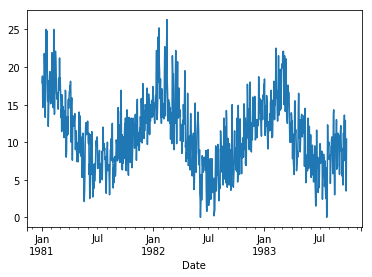

In [7]:
# create a Series object with your date column being the index
# plot it to see what your data looks like

from pandas import Series
data_clean = data
data_clean['Date'] = pd.to_datetime(data['Date'].apply(str))
# data_clean


# The code will create the dataset as a Pandas Series.
ts = Series(data['Daily_min_temp'].values, index=data.Date) 
plt = ts[1:1000].plot()
pyplot.show(plt)

##Quick Check for Autocorrelation

There is a quick, visual check that we can do to see if there is an autocorrelation in our time series dataset.  
Pandas provides a built-in plot to do exactly this, called the lag_plot() function.

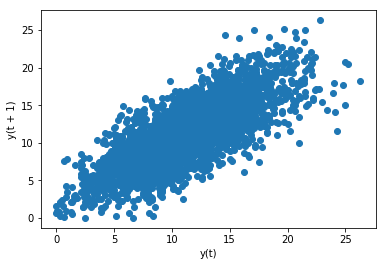

In [8]:
# quickly check for autocorrelation using the lag_plot function
from pandas.plotting import lag_plot
lag_plot(ts)
pyplot.show()

#### What do you notice?

I can recognize a dense cluster that has formed around a positive trend. This could indicate a relationship / correlation of the daily minimum temperatures.

## Autocorelation Plots

We can plot the correlation coefficient for each lag variable.  

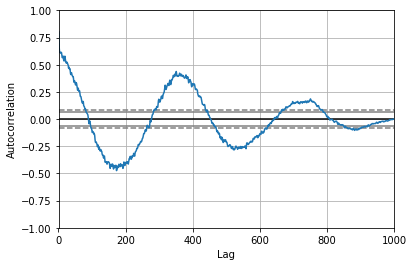

In [9]:
# use the autocorrelation_plot to get the correlation coefficient for each lag variable

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts[1:1000])
pyplot.show()

Using the statsmodels autocorrelation funciton, show the line plot (plot_acf)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


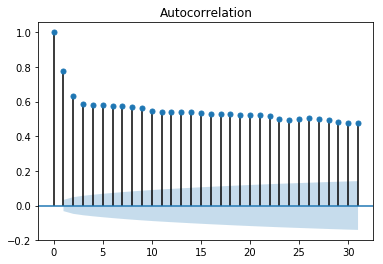

In [10]:
# use the plot_acf() fucntion

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts, lags=31)
pyplot.show()

#Autoregression Model

Use the statsmodels library to get the autoregression model that automatically selects an appropriate lag value using statistical tests.  

First create the model AR() and then call fit() to train it on your dataset. 

After the fit, make a prediction using the predict() function for about 7 day

Lag: 29
Coefficients: [  5.57543506e-01   5.88595221e-01  -9.08257090e-02   4.82615092e-02
   4.00650265e-02   3.93020055e-02   2.59463738e-02   4.46675960e-02
   1.27681498e-02   3.74362239e-02  -8.11700276e-04   4.79081949e-03
   1.84731397e-02   2.68908418e-02   5.75906178e-04   2.48096415e-02
   7.40316579e-03   9.91622149e-03   3.41599123e-02  -9.11961877e-03
   2.42127561e-02   1.87870751e-02   1.21841870e-02  -1.85534575e-02
  -1.77162867e-03   1.67319894e-02   1.97615668e-02   9.83245087e-03
   6.22710723e-03  -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test MSE: 1.502


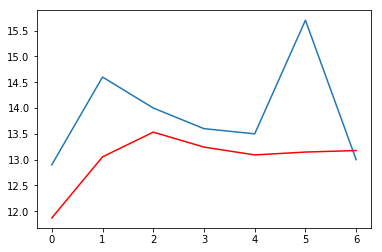

In [11]:
# use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an ARResult object.

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# split dataset to get only the values
ts_values = ts.values
train, test = ts_values[1:len(ts_values)-7], ts_values[len(ts_values)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


##Model Updates

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


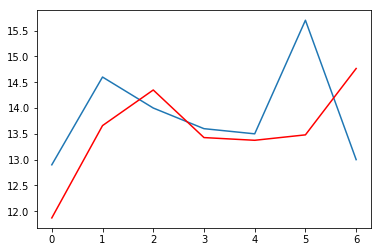

In [12]:
# adjust your model so the prediction are closer to the observed values

from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# split dataset
ts_values = ts.values
train, test = ts_values[1:len(ts_values)-7], ts_values[len(ts_values)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
